This is the notebook for Word2Vec

In [78]:
# Start gensim analysis with imports
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import datapath
import re
import unicodedata
from tqdm import tqdm
import gensim
import multiprocessing
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [79]:
reports = pd.read_csv('open_ave_data.csv')
reports = reports.dropna()
reports.head(3)

,Unnamed: 0,ReportText,findings,clinicaldata,ExamName,impression
0,0,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: Cough. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,IMPRESSION: Normal 2-view chest radiography.
1,1,EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 ...,IMPRESSION: No acute cardiopulmonary abnormali...
2,2,EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 ...,IMPRESSION: No acute cardiopulmonary process.


In [80]:
report_findings = reports['findings'].str.split().tolist()
report_clinicaldata = reports['clinicaldata'].str.split().tolist()
report_examname = reports['ExamName'].str.split().tolist()
report_impression = reports['impression'].str.split().tolist()
corpus = report_findings + report_clinicaldata + report_examname + report_impression

In [81]:
print(corpus[0])

['FINDINGS:', 'Lungs/Pleura:', 'No', 'focal', 'opacities', 'evident.', 'No', 'pleural', 'effusion.', 'No', 'pneumothorax.', 'Normal', 'volumes.', 'Mediastinum:', 'Heart', 'and', 'mediastinal', 'contours', 'are', 'unremarkable.', 'Other:', 'None.']


In [82]:
# Create empty gensim model
cores= multiprocessing.cpu_count()
model = Word2Vec(min_count=5,window=5,workers=cores-1,max_vocab_size=100000)

In [83]:
# Model using the dataset as the vocabulary
model.build_vocab(corpus)

In [84]:
# Train the model
model.train(corpus,total_examples=model.corpus_count,epochs=50)

(1462269, 2588300)

In [85]:
# Save the model
model.save('gensim_w2v_model.model')
# Load the model
# trained_model = gensim.models.Word2Vec.load('gensim_w2v_model.model')

In [86]:
# Create the embeddings
def embedding(sentence):
    vectors = []
    for word in sentence:
        try:
            vector = model.wv.get_vector(word)
        except KeyError:
            vector = [0] * 100
        except ValueError:
            continue
        vectors.append(vector)
    vector = np.sum(vectors, axis=0)
    return vector / len(sentence)


# X_embedded = [embedding(word) for word in corpus]
X_list = []
# for word
# print(embedding(corpus[0]))
# print(corpus[0])
# print(embedding(corpus))
for line in corpus:
    embed = embedding(line)
    X_list.append(embed.tolist())
    # print(embedding(line))
X_embedded = np.array(X_list)
X_embedded


array([[ 0.2555311 , -0.82267183, -0.06381932, ...,  0.40741882,
        -0.71673101, -0.27584931],
       [ 0.04379919, -0.63180339,  0.07207195, ...,  0.57229287,
         0.35570148,  0.01460459],
       [ 0.2555311 , -0.82267183, -0.06381932, ...,  0.40741882,
        -0.71673101, -0.27584931],
       ...,
       [-0.63537091, -0.32506666, -0.25046062, ...,  0.02259408,
        -0.77557534, -0.48565644],
       [-0.11736122, -0.45779172, -0.78641916, ..., -0.19430898,
        -0.96106321, -0.93790964],
       [ 0.02690895,  0.25205789, -0.2018373 , ..., -0.28713602,
         0.16249789, -0.72709557]])

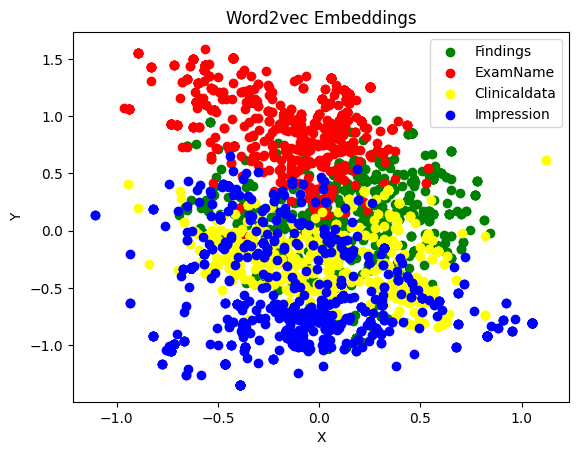

In [87]:
plt.title("Word2vec Embeddings")
plt.xlabel("X")
plt.ylabel("Y")

# Notation :,# takes all the columns from the number
lF = len(report_findings)
lC = len(report_clinicaldata)
lE = len(report_examname)
lI = len(report_impression)


plt.scatter(X_embedded[0:lF,0], X_embedded[0:lF,1], c='green')
plt.scatter(X_embedded[lF:lF+lC,0], X_embedded[lF:lF+lC,1], c='red')
plt.scatter(X_embedded[lF+lC:lF+lC+lE,0], X_embedded[lF+lC:lF+lC+lE,1], c='yellow')
plt.scatter(X_embedded[lF+lC+lE:,0], X_embedded[lF+lC+lE:,1], c='blue')
plt.legend(['Findings', 'ExamName','Clinicaldata','Impression'])

In [88]:
# Imports for supervised machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [89]:
# Examdata, clinical data, findings, impression combined for trainign
x = X_embedded
e = [0]*len(report_examname)
c = [1]*len(report_clinicaldata)
f= [2]*len(report_findings)
i=[3]*len(report_impression)
total = e+c+f+i
y = np.array(total)

In [90]:
# Apply train test split
x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.20, random_state=50, stratify=y)

In [91]:
# Regression - fits the model and returns it with the intercept and slope
model = LogisticRegression(multi_class='ovr', solver='liblinear')
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.9973684210526316

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

In [93]:
lr=LogisticRegression(C=1, solver ='saga')
lr.fit(x_train, y_train)
lr_preds=lr.predict(x_test)

print(confusion_matrix(y_test, lr_preds))
print(classification_report(y_test, lr_preds))
print("Accuracy Score: %.3f" % accuracy_score(y_test, lr_preds))

[[190   0   0   0]
 [  0 190   0   0]
 [  0   0 190   0]
 [  2   0   0 188]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       190
           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00       190
           3       1.00      0.99      0.99       190

    accuracy                           1.00       760
   macro avg       1.00      1.00      1.00       760
weighted avg       1.00      1.00      1.00       760

Accuracy Score: 0.997


c:\Users\elefe\OneDrive\Documents\Programming\Internships\OpenAv ML\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


c:\Users\elefe\OneDrive\Documents\Programming\Internships\OpenAv ML\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


array([[190,   0,   0,   0],
       [  0, 190,   0,   0],
       [  0,   0, 190,   0],
       [  2,   0,   0, 188]], dtype=int64)

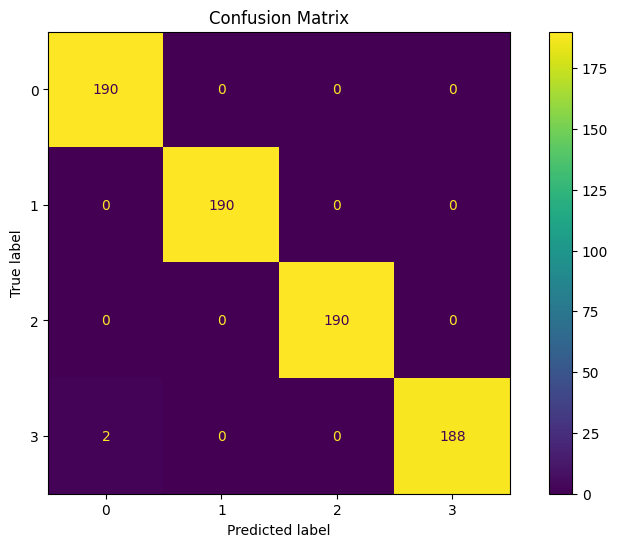

In [94]:
# Graph confusion matrix
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Confusion Matrix")
display = plot_confusion_matrix(model, x_test, y_test, ax=ax)
display.confusion_matrix